In [90]:
import os
import numpy as np

import cv2
import matplotlib.pyplot as plt
from PIL import Image

from skimage.segmentation import slic
from fast_slic import Slic

from mmseg.datasets import PascalVOCDataset
from torch.utils.data import DataLoader
import torch

In [4]:
val_dataset = PascalVOCDataset(
    data_root = '../data/VOCdevkit/VOC2012',
    data_prefix=dict(
        img_path='JPEGImages', seg_map_path='SegmentationClass'),
    ann_file='ImageSets/Segmentation/val.txt',
)

In [35]:
val_dataset[0]['img_path']

'../data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg'

(366, 500, 3)
(366, 500, 3)


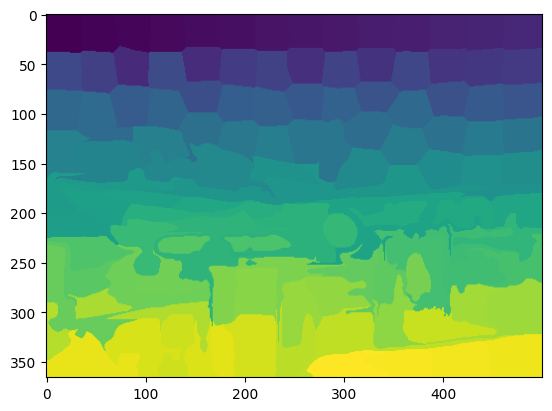

In [123]:
def compute_slic(im):
    segments_slic = slic(
        im, n_segments=150, compactness=6, sigma=3.0, start_label=0
    ).astype(np.uint8)
    # im = Image.fromarray(segments_slic)
    
    return segments_slic

def render_in_img(im, superpixels):
    superpixels_ids = np.unique(superpixels)
    mask = (superpixels == superpixel_id).astype(np.uint8)
    # red_mask = np.zeros_like(im)
    # red_mask[:, :, 2] = 255
    color = np.array([0,0,255])
    color = color[None, None, :]

    mask = mask * color
    masked_img = cv2.addWeighted(im, 0.7, mask.astype(np.uint8), 0.3, 0)
    # os.makedirs(os.path.join(out_base_dir, img_name.split(".")[0]), exist_ok=True)
    # cv2.imwrite(os.path.join(out_base_dir, img_name.split(".")[0], str(superpixel_id)+".jpg"), masked_img)
    # import ipdb
    # ipdb.set_trace()
    return masked_img



img = cv2.imread(val_dataset[0]['img_path'])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print (type(im))
# im = Image.open(val_dataset[11]['img_path'])
# print (type(im))

sp1 = slic(img, n_segments=150, compactness=6, sigma=3.0, start_label=0).astype(np.uint8)
print (sp.shape)
print (img.shape)
# im_render = render_in_img(im, im_seg)

plt.imshow(sp1)

2007_000033.jpg
(366, 500)


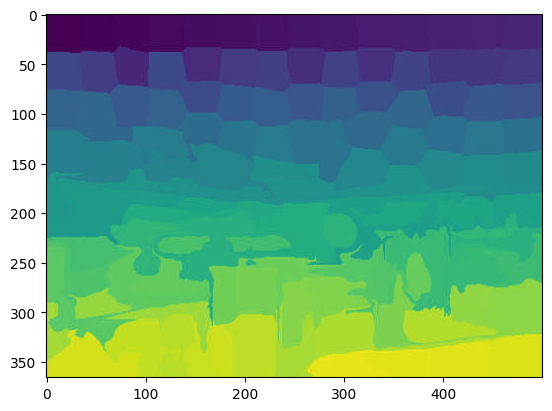

In [134]:
sp_dir = '../data/superpixel_img/slic150'
sps = os.listdir(sp_dir)
sps.sort()

# sp = cv2.imread(os.path.join(sp_dir, sps[0]))
sp_path = os.path.join(sp_dir, sps[0])
sp = Image.open(sp_path)
sp = np.array(sp)
print (sp.shape)
plt.imshow(sp)

In [146]:
sp_dir = '../data/superpixel_img/slic150'
sps = os.listdir(sp_dir)
sps.sort()

sp_path = os.path.join(sp_dir, sps[0])
sp = cv2.imread(sp_path) # B G R
# sp = Image.open(sp_path)
# sp = np.array(sp)

img_path = os.path.join('../data/VOCdevkit/VOC2012/JPEGImages', sps[0])
img = cv2.imread(img_path) # B G R

sp_ids = np.unique(sp)
ms = []
for id in sp_ids:
    m = (sp == id)
    ms.append(torch.tensor(m))
ms = torch.stack(ms, dim=0)
ms = ms.permute(0,3,1,2)

color = torch.tensor([[0,0,255], [0,255,0], [255,0,0]]) # R G B
# Red = color[0].reshape(1, 3, 1, 1)
# Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_repeated = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).expand_as(ms)
img_re = img_repeated * 0.6 + ms * Blue * 0.4
img_re.shape
sp_ids.shape

(122,)

In [158]:
def generate_batch(batch_files, reference_adv_dir, transform):
    batch = []
    gt_labels = []
    tar_labels = []
    imgs = []
    
    for file in batch_files:
        file_split = file.split('_')
        img_name = file_split[0]

        gt_labels.append(file_split[1])
        tar_labels.append(file_split[2].split('.')[0])
        batch.append(torch.from_numpy(np.load(os.path.join(reference_adv_dir, file))))

        img = Image.open(os.path.join('./dataset/images', img_name + '.png'))
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = transform(img)
        imgs.append(img)
    
    gt_labels = np.array(gt_labels).astype(np.int32)
    tar_labels = np.array(tar_labels).astype(np.int32)
    gt_labels = torch.from_numpy(gt_labels)
    tar_labels = torch.from_numpy(tar_labels)

    return torch.stack(batch), gt_labels, tar_labels, torch.stack(imgs)

reference_advs_files = os.listdir(reference_adv_dir)
num_batches = int(np.ceil(len(reference_advs_files) / batch_size))
reference_advs_files_batch = []
for i in range(num_batches):
    batch = reference_advs_files[i*args.batch_size: min((i+1)*args.batch_size, len(reference_advs_files))]
    reference_advs_files_batch.append(batch)

NameError: name 'reference_adv_dir' is not defined

In [160]:
val_dataset = PascalVOCDataset(
    data_root = '../data/VOCdevkit/VOC2012',
    data_prefix=dict(
        img_path='JPEGImages', seg_map_path='SegmentationClass'),
    ann_file='ImageSets/Segmentation/val.txt',
)
type(val_dataset)
len(val_dataset)

1449

In [187]:
def custom_collate_fn(batch):
    """
    Custom collate function to filter out None values.
    """
    # Filter out None values from the batch
    print (batch)
    batch = [{k: v for k, v in item.items() if v is not None} for item in batch]
            
    # Use default_collate to combine the filtered batch
    return torch.utils.data.dataloader.default_collate(batch)

# def custom_collate_fn(batch):
#     """
#     Custom collate function to handle None values in the samples.
#     """
#     # Remove keys with None values from each sample
#     filtered_batch = []
#     for item in batch:
#         filtered_item = {k: v for k, v in item.items() if v is not None}
#         filtered_batch.append(filtered_item)
    
#     return filtered_batch

val_loader = DataLoader(val_dataset, batch_size=2, collate_fn=custom_collate_fn)
next(iter(val_loader))

[{'img_path': '../data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg', 'seg_map_path': '../data/VOCdevkit/VOC2012/SegmentationClass/2007_000033.png', 'label_map': None, 'reduce_zero_label': False, 'seg_fields': [], 'sample_idx': 0}, {'img_path': '../data/VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg', 'seg_map_path': '../data/VOCdevkit/VOC2012/SegmentationClass/2007_000042.png', 'label_map': None, 'reduce_zero_label': False, 'seg_fields': [], 'sample_idx': 1}]


{'img_path': ['../data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg',
  '../data/VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg'],
 'seg_map_path': ['../data/VOCdevkit/VOC2012/SegmentationClass/2007_000033.png',
  '../data/VOCdevkit/VOC2012/SegmentationClass/2007_000042.png'],
 'reduce_zero_label': tensor([False, False]),
 'seg_fields': [],
 'sample_idx': tensor([0, 1])}

In [191]:
classes=['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
        'sofa', 'train', 'tvmonitor']
classes_str = ""
for name in classes:
    classes_str += (name + ", ")
classes_str = classes_str[:-2]
classes_str

'background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor'

In [212]:
a = [1, 2]
b = [3, 4]
bb = []
bb.append(torch.tensor(a))
bb.append(torch.tensor(b))
c = torch.stack(bb, dim=0)
c.shape

for x, y in zip(a, b):
    print (x, y)

1 3
2 4
